# How to load and use Cotrending Basis Vectors for Kepler, K2 and TESS

Cotrending Basis Vectors (CBVs) are generated in the PDC component of the Kepler/K2/TESS pipeline and are used to remove systematic trends in light curves. They are built from the most common systematic trends observed in each PDC Unit of Work (Quarter for Kepler, Campaign for K2 and Sector for TESS). Each Kepler and K2 module output and each CCD in TESS has its own set of CBVs. You can read an introduction to the CBVs in [Demystifying Kepler Data](https://arxiv.org/pdf/1207.3093.pdf) or to greater detail in the [Kepler Data Processing Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19081-003-KDPH.pdf). The same basic method to generate CBVs is used for all three missions.

This tutorial provides examples of how to load CBVs from MAST and set them up in a design matrix for use to remove systematic trends. Please consult the [DesignMatrix page](../api/lightkurve.correctors.DesignMatrix.html) in the API docs for the full details on that class. A convenient tool has been created called `CBVCorrector` which will utilize the CBVs for the custom removal of systematic trends. See the [CBVCorrector HOWTO page](https://docs.lightkurve.org/tutorials/04-how-to-use-cbvcorrector.html) for example usage.

## Cotrending Basis Vector Types

There are three basic types of CBVs: 
- **Single-Scale** contains all systematic trends combined in a single set of basis vectors. 
- **Multi-Scale** contains systematic trends in specific wavelet-based band passes. There are usually three sets of multi-scale basis vectors in three bands.
- **Spike** contains only short impulsive spike systematics.

There are two different correction methods in PDC: Single-Scale and Multi-Scale. Single-Scale performs the correction in a single bandpass. Multi-Scale performs the correction in three separate wavelet-based bandpasses. Both corrections are performed in PDC but we can only export a single PDC light curve for each target. So, PDC must choose which of the two on a per-target basis. Generally speaking, single-scale performs better at preserving longer period signals. But at periods close to transiting planet durations multi-scale performs better at preserving signals. PDC therefore mostly chooses multi-scale for use within the planet finding pipeline and for the archive. You can find in the light curve FITS header which PDC method was chosen (keyword “PDCMETHD”). Additionally, a seperate correction is alway performed to remove short impulsive systematic spikes.

For an individual's research needs, the mission supplied PDC lightcurves might not be ideal and so the CBVs are provided to the user to perform their own correction. All three CBV types are provided at MAST for TESS, however only Single-Scale is provided at MAST for Kepler and K2. For TESS, Cotrending Basis Vectors are currently only supplied at a 2-minute cadence. For Kepler/K2 only for the 30-minute target cadence.

## Obtaining the CBVs

Two tools are available to automatically download the CBVs relevent to your target of study: `get_kepler_cbvs` and `get_tess_cbvs`. Here is an example loading in the TESS Multi-Scale Band 2 CBVs for TESS target TIC 99180739, which happens to be on camera 1 and CCD 1. Note that you do not need to have a lightcurve object already loaded. One can directly request whichever CBVs one desires.

In [1]:
from lightkurve import search_lightcurve
from lightkurve.correctors import download_tess_cbvs, download_kepler_cbvs
import numpy as np
lc = search_lightcurve('TIC 99180739', author='SPOC', sector=10).download(flux_column='sap_flux')
cbvs = download_tess_cbvs(sector=lc.sector, camera=lc.camera, ccd=lc.ccd, cbv_type='MultiScale', band=2)

This TessCotrendingBasisVectors object contains 8 Multi-Scale band 2 CBVs for Sector 10, Camera 1, CCD 1. A CBV object contains only one type of CBVs. To obtain all types you must request each seperately. The basis vectors themselves are containted in an astropy.timeseries.TimeSeries Table:

In [2]:
# Show the head of the CBV table
cbvs[1:4]

time,CADENCENO,GAP,VECTOR_1,VECTOR_2,VECTOR_3,VECTOR_4,VECTOR_5,VECTOR_6,VECTOR_7,VECTOR_8
,,,,,,,,,,
object,int32,bool,float32,float32,float32,float32,float32,float32,float32,float32
1569.43314028183,246224,False,-0.003580346703529358,-0.0025399853475391865,0.0003182471264153719,-0.005101832095533609,0.0019720413256436586,-0.002591928234323859,-0.00848366692662239,0.009498000144958496
1569.4345291701247,246225,False,-0.003526911837980151,-0.0024424500297755003,0.00030286889523267746,-0.004837454296648502,0.002021507592871785,-0.0025524157099425793,-0.008463572710752487,0.009511380456387997
1569.4359180584206,246226,False,-0.0034735281951725483,-0.002345119370147586,0.0002874816709663719,-0.004573645535856485,0.0020708078518509865,-0.0025129010900855064,-0.008443333208560944,0.009524472057819366


All data contained in the MAST CBV FITS files is downloaded. The `time`, `CADENCENO` and `GAP` columns can be used to select which cadences you desire. Extra information is in the `cbvs.meta` dict. The CBVS are interpolated accross the gaps and so should be used in gapped cadences with extreme caution. Below we will plot the first 4 CBVs. Note: _CBVs use 1-based indexing!_

<AxesSubplot:title={'center':'TESS CBVs (Sector.Camera.CCD : 10.1.1, CBVType.Band : MultiScale.2)'}, xlabel='Time [btjd]'>

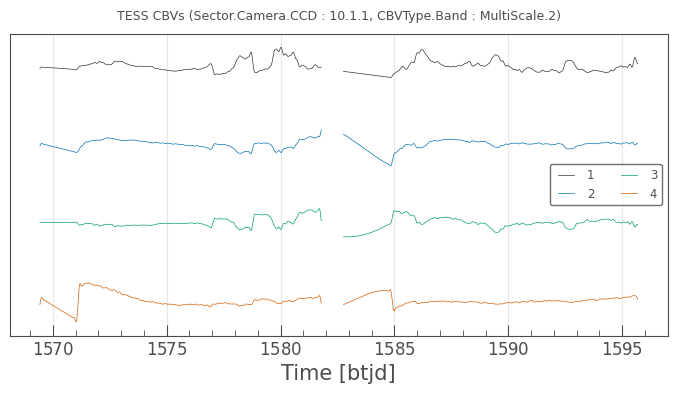

In [3]:
cbvs.plot(cbv_indices=np.arange(1,5));

 As further examples, below we will request both Kepler and K2 CBVs.

In [4]:
cbvsKepler = download_kepler_cbvs(mission='Kepler', quarter=8, module=16, output=4)
cbvsK2 = download_kepler_cbvs(mission='K2', campaign=15, channel=24)

## Converting the CBVs to a Lightkurve `DesignMatrix`

You can access individual CBVs directly by referencing the column in the table (i.e. `cbvs['VECTOR_#']`) however a better way to use the CBVs for correcting your light curves is to convert the CBVs to a LightKurve DesignMatrix:

In [5]:
cbv_designmatrix = cbvs.to_designmatrix(cbv_indices=np.arange(1,9), name='10.1.1.SingleScale')
cbv_designmatrix

10.1.1.SingleScale DesignMatrix (18900, 8)

<AxesSubplot:title={'center':'10.1.1.SingleScale'}, xlabel='Component', ylabel='X'>

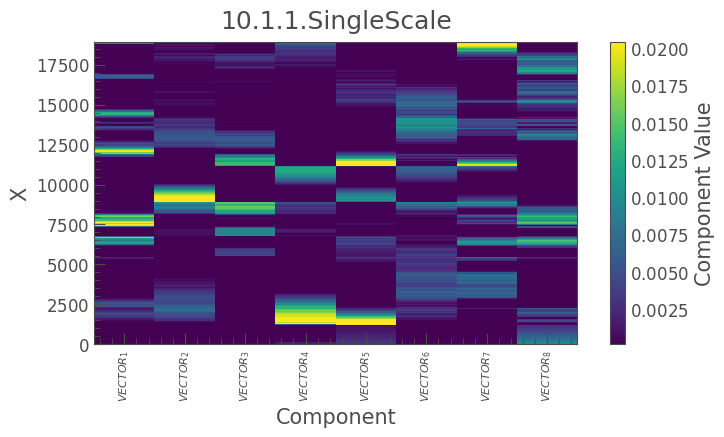

In [6]:
cbv_designmatrix.plot();

## Aligning the CBVs with your light curve

The CBVs obtained from MAST may not have the same cadences as the your target. A method called `align` will allow you to align your CBVs to the cadence numbers in your target lightcurve object. The method will use the cadence number (i.e. `lc.cadenceno`) to perform the alignment. Only cadence numbers that exist in both the CBVs and the light curve will have values in the returned CBVs. All cadence numbers that exist in the light curve but not in the CBVs will have NaNs returned for the CBVs on those cadences and the GAP set to True.

In [7]:
# Take a cut of the LC loaded above
lc_short = lc[501:1501]
# Take a different cut of the CBVs
cbvs_short = cbvs[0:1000]
# These cuts do not overlap
np.all(lc_short.cadenceno == cbvs_short.cadenceno)

False

In [8]:
# Align the cuts
cbvs_aligned = cbvs_short.align(lc_short)
# They now fully overlap
np.all(lc_short.cadenceno == cbvs_aligned.cadenceno)

True

## Interpolating the CBVs to an arbitrary light curve

The above `align` method will only keep cadences that line up exactly between the CBVs and the light curve based on the cadence numbers. What if you have a light curve with cadence times not exactly lining up with the CBV cadences? For example, what if you want to use the 2-minute CBVs for cotrending against the 30-minute FFIs? A more general method is `inteprolate`, which uses PCHIP interpolation to generate CBVs at the cadence times of an arbitrary light curve.

In [9]:
# Get a light curve from a TESS FFI
from lightkurve import search_tesscut
search_result = search_tesscut('HAT-P-11', sector=14)
tpf = search_result.download(cutout_size=20)
target_mask = tpf.create_threshold_mask(threshold=15, reference_pixel='center')
ffi_lc = tpf.to_lightcurve(aperture_mask=target_mask)

In [10]:
# Get the Single-Scale CBVs for this light curve
cbvs = download_tess_cbvs(sector=ffi_lc.sector, camera=ffi_lc.camera, ccd=ffi_lc.ccd, cbv_type='SingleScale')

In [11]:
# Interpolate the CBVs to the FFI cadence times
cbvs_interpolated = cbvs.interpolate(ffi_lc, extrapolate=False)

In [12]:
# All cadence times agree
np.all(ffi_lc.time.value == cbvs_interpolated.time.value)

True

<AxesSubplot:title={'center':'TESS CBVs (Sector.Camera.CCD : 14.2.4, CBVType : SingleScale)'}, xlabel='Time [btjd]'>

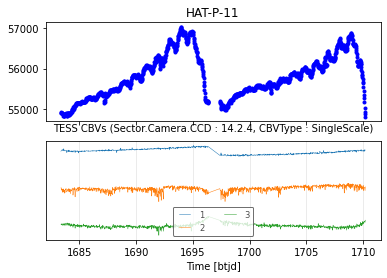

In [13]:
# The CBVs are now interpolated to this FFI-derived light curve
import matplotlib.pyplot as plt
_, ax = plt.subplots(2, sharex=True)
ax[0].plot(ffi_lc.time.value, ffi_lc.flux, '.b')
ax[0].set_title('HAT-P-11')
cbvs_interpolated.plot(cbv_indices=np.arange(1,4), ax=ax[1]);

### Some notes about interpolating Cotrending Basis Vectors

- Currently, only TESS 2-minute and Kepler/K2 30-minute CBVs are archived on MAST
- 20-second CBVs will be available for the TESS extended mission beginning with Sector 27. Each set of 20-second CBVs will be for the entire field of view.
- FFI CBVs are also being developed and will begin to be exported soon.
- The CBVs are generated to account for systematics at a specific cadence. They will not necessarily properly represent systematics at a different cadence, but in some cases can still be beneficial.
- Please remain conscious of the Nyquist frequency and aliasing when interpolating CBVs.